In [1]:
import datetime as dt
import logging
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from IPython import display
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from typing import Collection, List

from volfitter.adapters.current_time_supplier import AbstractCurrentTimeSupplier
from volfitter.adapters.final_iv_consumer import AbstractFinalIVConsumer
from volfitter.composition_root import create_volfitter_service
from volfitter.config import VolfitterConfig
from volfitter.domain.datamodel import (
    FinalIVCurve,
    FinalIVSurface,
    OptionKind,
    RawIVPoint,
    RawIVSurface,
)
from volfitter.domain.fitter import MidMarketSurfaceFitter

# When no log file is specified, logging is by default sent to stderr, and the default level is WARNING.
# We don't care to see the warning logs here in the notebook, so set the level to ERROR.
logging.basicConfig(level=logging.ERROR)

# In the CLI application, warnings are redirected to the log file. We suppress them in the notebook.
warnings.filterwarnings("ignore")

mpl.rcParams["figure.figsize"] = [12, 8]

sns.set()

# Volfitter Visualization

This notebook runs the volfitter on the sample data and visualizes the output. The following visualizations are supported:

- Plotting a single expiry on a given date. The fitted curve is displayed along with raw IV quotes.
- Plotting a single expiry's evolution over time. The fitter iterates over all dates in the sample data.
- Plotting a fixed time-to-expiry's evolution over time. The fitter iterates over all dates in the sample data, at each date displaying the nearest expiry with at least the specified number of days to expiry.
- Plotting the vol surface on a given date. Both the fitted surface and the mid-market surface are displayed.
- Plotting the vol surface's evolution over time. The fitter iterates over all dates in the sample data.

# Volfitter Config

One can set parameters on the VolfitterConfig to visualize the output of the fitter under different configurations. A printout of the available parameters is included below.

In [2]:
VOLFITTER_CONFIG = VolfitterConfig.from_environ(
    {
        "VOLFITTER_RAW_IV_FILTERING_CONFIG_MAX_LAST_TRADE_AGE_DAYS": 3,
    }
)

In [3]:
print(VOLFITTER_CONFIG.generate_help(display_defaults=True))

VOLFITTER_SYMBOL (Optional, Default=AMZN): The underlying symbol.
VOLFITTER_VOLFITTER_MODE (Optional, Default=VolfitterMode.SAMPLE_DATA): Mode in which to run the volfitter.
VOLFITTER_LOG_FILE (Optional, Default=/Users/cberger/repos/volfitter/src/volfitter/../../logs/volfitter.log): The log file.
VOLFITTER_FIT_INTERVAL_S (Optional, Default=10): Fit interval in seconds.
VOLFITTER_SURFACE_MODEL (Optional, Default=SurfaceModel.SVI): The implied volatility surface model to fit to the market.
VOLFITTER_SAMPLE_DATA_CONFIG_INPUT_DATA_PATH (Optional, Default=/Users/cberger/repos/volfitter/src/volfitter/../../data/input): The input data path.
VOLFITTER_SAMPLE_DATA_CONFIG_OPTION_DATA_FILE_SUBSTRING (Optional, Default=option_data): Option data will be loaded from all files in the input directory whose filenames contain this substring.
VOLFITTER_SAMPLE_DATA_CONFIG_FORWARD_DATA_FILE_SUBSTRING (Optional, Default=forward_prices): Forward prices will be loaded from all files in the input directory who

# Notebook Adapters and Plotting Code

The code in this section can be ignored if one is just interested in running the notebook and seeing the results.

In [4]:
class NotebookCurrentTimeSupplier(AbstractCurrentTimeSupplier):
    def __init__(self, current_time: dt.datetime):
        self.current_time = current_time

    def get_current_time(self) -> dt.datetime:
        return self.current_time

In [5]:
class NotebookFinalIVConsumer(AbstractFinalIVConsumer):
    def __init__(self):
        self.latest_surface = None

    def consume_final_iv_surface(self, final_iv_surface: FinalIVSurface) -> None:
        self.latest_surface = final_iv_surface

In [6]:
class InterpolatingIVCurve:
    """
    This class is used to construct the 3D surface plots.

    It just interpolates vol linearly in strike, which is sufficient for visualization.
    """

    def __init__(self, final_iv_curve: FinalIVCurve):
        sorted_points = sorted(
            final_iv_curve.points.values(), key=lambda point: point.strike
        )
        self.strikes = [point.strike for point in sorted_points]
        self.vols = [point.vol for point in sorted_points]

    def get_vol(self, strike: float) -> float:
        if strike <= self.strikes[0]:
            return self._extrapolate_below(strike)
        elif strike > self.strikes[-1]:
            return self._extrapolate_above(strike)
        else:
            return self._interpolate(strike)

    def _extrapolate_below(self, strike: float) -> float:
        return self._polate(strike, 0, 1)

    def _extrapolate_above(self, strike: float) -> float:
        return self._polate(strike, -2, -1)

    def _interpolate(self, strike: float) -> float:
        right_index = np.searchsorted(self.strikes, strike)
        left_index = right_index - 1

        return self._polate(strike, left_index, right_index)

    def _polate(self, strike: float, left_index: int, right_index: int) -> float:
        strike_step = self.strikes[right_index] - self.strikes[left_index]
        vol_step = self.vols[right_index] - self.vols[left_index]

        strike_dist = strike - self.strikes[left_index]
        start_vol = self.vols[left_index]

        return start_vol + vol_step * strike_dist / strike_step

In [7]:
def plot_expiry(
    date: dt.datetime,
    expiry: dt.datetime,
    final_iv_surface: FinalIVSurface,
    raw_iv_surface: RawIVSurface,
    ylim=(0.1, 1.5),
) -> None:
    raw_curve = raw_iv_surface.curves[expiry]

    calls = [
        point
        for point in raw_curve.points.values()
        if point.option.kind == OptionKind.CALL
    ]
    puts = [
        point
        for point in raw_curve.points.values()
        if point.option.kind == OptionKind.PUT
    ]

    add_markets_to_plot(calls, "r")
    add_markets_to_plot(puts, "b")

    final_curve = final_iv_surface.curves[expiry]
    add_curve_to_plot(final_curve)

    plt.xlabel("$K$", fontsize=14)
    plt.ylabel("$\sigma$", fontsize=14)
    plt.title(
        f"[{VOLFITTER_CONFIG.symbol}]   t = {date.date()}   "
        f"Expiry = {expiry.date()}   {(expiry.date() - date.date()).days} days to expiry"
        f"\n\n{final_curve.status.tag.name}: {final_curve.status.message}",
        fontsize=16,
    )
    plt.ylim(ylim)


def add_markets_to_plot(raw_iv_points: List[RawIVPoint], color: str) -> None:
    sorted_points = sorted(raw_iv_points, key=lambda point: point.option.strike)

    bids = np.zeros(len(sorted_points))
    asks = np.zeros(len(sorted_points))
    strikes = np.zeros(len(sorted_points))
    for i, point in enumerate(sorted_points):
        bids[i] = point.bid_vol
        asks[i] = point.ask_vol
        strikes[i] = point.option.strike

    plt.scatter(strikes, asks, color=color, marker="v")
    plt.scatter(strikes, bids, color=color, marker="^")


def add_curve_to_plot(final_iv_curve: FinalIVCurve) -> None:
    sorted_points = sorted(
        final_iv_curve.points.values(), key=lambda point: point.strike
    )
    strikes = np.zeros(len(sorted_points))
    vols = np.zeros(len(sorted_points))
    for i, point in enumerate(sorted_points):
        strikes[i] = point.strike
        vols[i] = point.vol

    plt.plot(strikes, vols, color="orange", linewidth=2)

In [8]:
def plot_surfaces(
    date: dt.datetime, midmarket_surface: FinalIVSurface, fitted_surface: FinalIVSurface
) -> None:
    fig = plt.figure(figsize=(20, 40))
    add_surface_subplot(fig, 1, "Mid-market", date, midmarket_surface)
    add_surface_subplot(fig, 2, "SVI", date, fitted_surface)


def add_surface_subplot(
    fig: plt.Figure,
    subplot_number: int,
    surface_name: str,
    date: dt.datetime,
    final_iv_surface: FinalIVSurface,
) -> None:
    ax = fig.add_subplot(1, 2, subplot_number, projection="3d")

    strikes = sorted(
        list(
            set().union(
                *[
                    set(curve.points.keys())
                    for curve in final_iv_surface.curves.values()
                ]
            )
        )
    )
    expiries = sorted(
        [expiry for expiry in final_iv_surface.curves.keys() if expiry > date]
    )
    ttes = [(expiry.date() - date.date()).days / 365 for expiry in expiries]

    vols = np.zeros((len(expiries), len(strikes)))
    for i, expiry in enumerate(expiries):
        curve = InterpolatingIVCurve(final_iv_surface.curves[expiry])
        for j, strike in enumerate(strikes):
            vols[i, j] = curve.get_vol(strike)

    strikes, ttes = np.meshgrid(strikes, ttes)

    surface = ax.plot_surface(
        ttes,
        strikes,
        vols,
        cmap="YlGnBu_r",
        norm=colors.LogNorm(vmin=0.05, vmax=5),
        linewidth=0,
        antialiased=False,
    )

    ax.set_zlim(0.1, 1.5)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter("{x:.02f}")

    ax.set_xlabel("$\\tau$", fontsize=14)
    ax.set_ylabel("$K$", fontsize=14)
    ax.set_zlabel("$\sigma$", fontsize=14)

    plt.title(
        f"[{VOLFITTER_CONFIG.symbol}] {surface_name} volatility surface, t = {date.date()}",
        fontsize=16,
    )

# Plot fixed expiry

In [9]:
DATE = dt.datetime(2020, 1, 16, 15, 0)
EXPIRY = dt.datetime(2020, 2, 21, 15, 0)

In [10]:
def plot_fixed_expiry(date: dt.datetime, expiry: dt.datetime) -> None:
    current_time_supplier = NotebookCurrentTimeSupplier(date)
    final_iv_consumer = NotebookFinalIVConsumer()

    # Create VolfitterService with the normal sample data adapters,
    # then patch in our notebook adapters
    volfitter_service = create_volfitter_service(VOLFITTER_CONFIG)
    volfitter_service.current_time_supplier = current_time_supplier
    volfitter_service.final_iv_consumer = final_iv_consumer

    volfitter_service.fit_full_surface()

    plot_expiry(
        date,
        expiry,
        final_iv_consumer.latest_surface,
        volfitter_service.raw_iv_supplier.get_raw_iv_surface(date),
    )

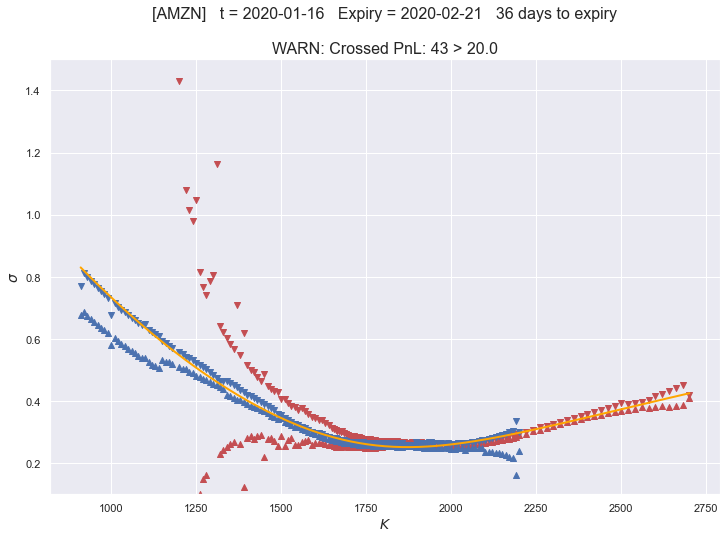

In [11]:
plot_fixed_expiry(DATE, EXPIRY)

# Plot fixed expiry's evolution over time

In [ ]:
EXPIRY = dt.datetime(2020, 1, 24, 15, 0)

In [ ]:
def plot_fixed_expiry_evolution(expiry: dt.datetime) -> None:
    final_iv_consumer = NotebookFinalIVConsumer()

    volfitter_service = create_volfitter_service(VOLFITTER_CONFIG)
    volfitter_service.final_iv_consumer = final_iv_consumer

    # In practice, a single call to fit_full_surface takes ~1.5s. Thus,
    # we can simply do 'while True' and the plot will update at a reasonable
    # frequency for visualization.

    # N.B. Most of that 1.5s is actually spent doing the "last trade date"
    # check. The fitting itself takes ~100ms for the entire surface.
    while True:
        volfitter_service.fit_full_surface()

        final_surface = final_iv_consumer.latest_surface

        # If the expiry has not been listed yet:
        if expiry not in final_surface.curves:
            continue

        if "Expired" in final_surface.curves[expiry].status.message:
            display.clear_output(wait=True)
            return

        date = final_surface.datetime

        plt.gca().cla()
        plot_expiry(
            date,
            expiry,
            final_surface,
            volfitter_service.raw_iv_supplier.get_raw_iv_surface(date),
        )
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
plot_fixed_expiry_evolution(EXPIRY)

# Plot fixed time-to-expiry evolution over time

In [ ]:
# At each time step, we will plot the nearest expiry that is at least this many days out

DAYS_TO_EXPIRY = 7

In [ ]:
def find_nearest_expiry_with_at_least_days_to_expiry_remaining(
    date: dt.datetime, expiries: Collection[dt.datetime], days_to_expiry: int
) -> dt.datetime:
    sorted_expiries = sorted(expiries)
    for expiry in sorted_expiries:
        if expiry - date >= dt.timedelta(days=days_to_expiry):
            return expiry

In [ ]:
def plot_fixed_time_to_expiry_evolution(days_to_expiry: int) -> None:
    final_iv_consumer = NotebookFinalIVConsumer()

    volfitter_service = create_volfitter_service(VOLFITTER_CONFIG)
    volfitter_service.final_iv_consumer = final_iv_consumer

    while True:
        volfitter_service.fit_full_surface()

        final_surface = final_iv_consumer.latest_surface

        date = final_surface.datetime

        expiry = find_nearest_expiry_with_at_least_days_to_expiry_remaining(
            date, final_surface.curves.keys(), days_to_expiry
        )

        plt.gca().cla()
        plot_expiry(
            date,
            expiry,
            final_surface,
            volfitter_service.raw_iv_supplier.get_raw_iv_surface(date),
        )
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
plot_fixed_time_to_expiry_evolution(DAYS_TO_EXPIRY)

# Plot fixed surface

In [12]:
DATE = dt.datetime(2020, 2, 3, 15, 0)

In [13]:
def plot_fixed_surface(date: dt.datetime) -> None:
    current_time_supplier = NotebookCurrentTimeSupplier(date)
    final_iv_consumer = NotebookFinalIVConsumer()

    volfitter_service = create_volfitter_service(VOLFITTER_CONFIG)
    volfitter_service.current_time_supplier = current_time_supplier
    volfitter_service.final_iv_consumer = final_iv_consumer

    volfitter_service.fit_full_surface()

    midmarket_fitter = MidMarketSurfaceFitter()
    midmarket_surface = midmarket_fitter.fit_surface_model(
        volfitter_service.raw_iv_supplier.get_raw_iv_surface(date), {}
    )

    plot_surfaces(date, midmarket_surface, final_iv_consumer.latest_surface)

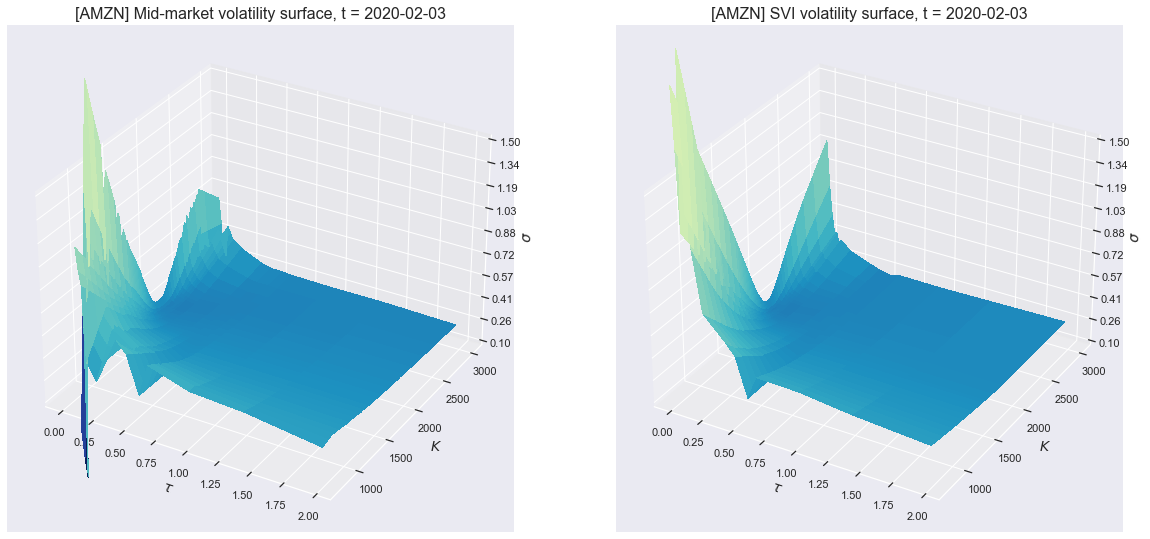

In [14]:
plot_fixed_surface(DATE)

# Plot surface evolution over time

In [ ]:
def plot_surface_evolution() -> None:
    final_iv_consumer = NotebookFinalIVConsumer()

    volfitter_service = create_volfitter_service(VOLFITTER_CONFIG)
    volfitter_service.final_iv_consumer = final_iv_consumer

    while True:
        volfitter_service.fit_full_surface()

        final_surface = final_iv_consumer.latest_surface
        date = final_surface.datetime

        midmarket_fitter = MidMarketSurfaceFitter()
        midmarket_surface = midmarket_fitter.fit_surface_model(
            volfitter_service.raw_iv_supplier.get_raw_iv_surface(date), {}
        )

        plt.gca().cla()
        plot_surfaces(date, midmarket_surface, final_iv_consumer.latest_surface)
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
plot_surface_evolution()